# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [298]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [299]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
19796,27913,72865,@literary.libations on Instagr,26-03-2020,From Reuters March 11th:\r\r\n\r\r\nÃÂU.S. c...,Extremely Negative
26134,35813,80765,"South Tottenham, London, UK",07-04-2020,SHOPPING ONLINE You can donate items on our ...,Positive
17655,25271,70223,"Providence, RI (Mt. Pleasant)",25-03-2020,"COVID-19 should encourage us to pay ALL ""essen...",Positive
11112,17285,62237,United States,21-03-2020,"@senatemajldr No bailouts airlines, hotels, cr...",Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [300]:
positive_labels = ['Positive', 'Extremely Positive']
negative_labels = ['Negative', 'Extremely Negative']

def sentiment_to_bin(sentiment: str) -> int:
    if sentiment in positive_labels:
        return 1
    elif sentiment in negative_labels:
        return 0
    else:
        return None

df['Sentiment'] = df['Sentiment'].apply(sentiment_to_bin)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [301]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

In [302]:
count_positive = df['Sentiment'].value_counts()[1]
count_negative = df['Sentiment'].value_counts()[0]

count_all = count_positive + count_negative
print(f"Процент позитивных твиттов: {count_positive / count_all * 100:.2f}")
print(f"Процент негавтивных твиттов: {count_negative / count_all * 100:.2f}")

Процент позитивных твиттов: 53.96
Процент негавтивных твиттов: 46.04


**Ответ:** Процентная разница совсем небольшая, поэтому будем считать, что классы сбалансированны.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [303]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Есть 7049 пропусков в признаке `Location`.

In [304]:
df = df.fillna('Unknown')
df.isna().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [305]:
from sklearn.model_selection import train_test_split

train, test =  train_test_split(df, test_size=0.3, random_state=0, stratify=df['Sentiment'])

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [306]:
tokens = {}

for tweet in train['OriginalTweet']:
    words = tweet.lower().split()
    
    for word in words:
        if word in tokens:
            tokens[word] += 1
        else:
            tokens[word] = 1

Какой размер словаря получился?

In [307]:
len(tokens)

80027

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [308]:
top_tokens = pd.DataFrame(list(tokens.items()), columns=['Token', 'Count'])
top_tokens = top_tokens.sort_values(by='Count', ascending=False).reset_index(drop=True)

top_tokens.head(10)

,Token,Count
0,the,26708
1,to,23432
2,and,14535
3,of,13123
4,a,11754
5,in,11291
6,for,8571
7,#coronavirus,8222
8,is,7411
9,are,7020


**Ответ:** Эти слова являются служебными в английском языке, они часто используются как вспомогательные элементы, союзы, артикли и предлоги для составления грамматически правильных предложений. Также токен `#coronavirus` является часто втречаемым, потому что этот хештег является основной темой данных твиттов.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import ssl
import certifi
import nltk
from nltk.corpus import stopwords

ssl._create_default_https_context = ssl.create_default_context(cafile=certifi.where())

# Были страдания с загрузкой этих стоп-слов...
nltk.data.path.append("/Users/alexvasyukov/nltk_data/corpora/stopwords")

tokens_without_stopwords = tokens.copy()

for token in tokens:
    if str.lower(token) in stopwords.words('english'):
        tokens_without_stopwords.pop(token)

top_tokens_without_stopwords = pd.DataFrame(list(tokens_without_stopwords.items()), columns=['Token', 'Count'])
top_tokens_without_stopwords = top_tokens_without_stopwords.sort_values(by='Count', ascending=False).reset_index(drop=True)

top_tokens_without_stopwords.head(10)

,Token,Count
0,#coronavirus,8222
1,prices,3906
2,food,3804
3,grocery,3442
4,supermarket,3250
5,covid-19,3188
6,store,3142
7,people,3113
8,#covid19,2473
9,consumer,2288


**Ответ:**  Теперь наиболее часто встречаемые слова - это слова, которые сильно связаны с темой твиттов, с коронавирусом. Пандемия повлияла на многие повседневные отросли, в том числе на магазины, продукты, поэтому среди популярных слов такие, как `prices`, `food`, `grocery`, `supermarket`, `store`. Также часто встречаются сами названия вируса в разных формах: `#coronavirus`, `covid-19`, `#covid19`. 

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [310]:
antitop_tokens_without_stopwords = pd.DataFrame(list(tokens_without_stopwords.items()), columns=['Token', 'Count'])
antitop_tokens_without_stopwords = antitop_tokens_without_stopwords.sort_values(by='Count', ascending=True).reset_index(drop=True)

antitop_tokens_without_stopwords.head(20)

,Token,Count
0,https://t.co/4xnxwr3kq7,1
1,#michiganross,1
2,"radio,",1
3,https://t.co/lgaipdg44f,1
4,loon.,1
5,bible,1
6,mocked,1
7,prof.,1
8,https://t.co/82enerilrt,1
9,"purchasing,",1


**Ответ:** Здесь токены, которые встречались лишь раз среди всех твиттов. Они непопулярны, так как в некоторые включена пунктуация, но комбинация какого-то слова и знака препинания часто уникальна и используется редко. Ещё есть слова с опечатками. Также тут есть ссылки на сайты, которые цитируются довольно редко.

Возможно, их можно просто удалить, они сильного смыслового значения не несут, и тогда результат всё равно не должен сильно измениться. Но стоит учесть, что иногда скобочки могут показать окрас сообщения.

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [311]:
from nltk.tokenize import TweetTokenizer

nltk.data.path.append("/Users/alexvasyukov/nltk_data/punkt")

tw = TweetTokenizer()
tokens = {}

for tweet in train['OriginalTweet']:
    words = tw.tokenize(tweet.lower())

    for word in words:
        if word in tokens:
            tokens[word] += 1
        else:
            tokens[word] = 1

top_tokens = pd.DataFrame(list(tokens.items()), columns=['Token', 'Count'])
top_tokens = top_tokens.sort_values(by='Count', ascending=False).reset_index(drop=True)

top_tokens.head(10)

,Token,Count
0,the,26882
1,.,23953
2,to,23526
3,",",17620
4,and,14674
5,of,13147
6,a,11896
7,in,11426
8,?,9525
9,#coronavirus,8795


**Ответ:** Здесь так же есть служебные слова, такие как `the`, `to`, `and` и другие. Но к этому добавились знаки препинания `.`, `,`, `?`, которых не было ранее. Это получается из-за того, что TweetTokenizer учитывает различные комбинации символов (эомдзи, знаки препинания) как отдельные токены, а до этого мы просто делили слова по пробелам. И пунктуация должна иметь большое значение на нашу модель, так как она может передавать эмоции.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [312]:
from string import punctuation

noise = stopwords.words('english') + list(punctuation)
tokens_without_noise = tokens.copy()

for token in tokens:
    if token in noise:
        tokens_without_noise.pop(token)

top_tokens_without_stopwords = pd.DataFrame(list(tokens_without_noise.items()), columns=['Token', 'Count'])
top_tokens_without_stopwords = top_tokens_without_stopwords.sort_values(by='Count', ascending=False).reset_index(drop=True)

top_tokens_without_stopwords.head(10)

,Token,Count
0,#coronavirus,8795
1,â,7319
2,,7222
3,19,7180
4,covid,6237
5,prices,4599
6,food,4362
7,,4315
8,store,3868
9,supermarket,3797


**Ответ:** Результаты содержат одинаковые слова, которые были ранее, связанные с магазинами `prices`, `food`, `store` и с вирусом `#coronavirus`, `#covid19`. К тому же доавбились невидимые символы и символы выходящие из кодировки - их TweetTokenizer выделил как отдельные токены, в отличие от прошлого раза. Также 19 отделилось от ковида, что сделало интерпретацию немного хуже.

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [313]:
final_tokens = tokens_without_noise.copy()

for token in tokens_without_noise:
    if len(token) == 1 and ord(token) >= 128:
        final_tokens.pop(token)

In [314]:
top_final_tokens = pd.DataFrame(list(final_tokens.items()), columns=['Token', 'Count'])
top_final_tokens = top_final_tokens.sort_values(by='Count', ascending=False).reset_index(drop=True)

top_final_tokens.head(10)

,Token,Count
0,#coronavirus,8795
1,19,7180
2,covid,6237
3,prices,4599
4,food,4362
5,store,3868
6,supermarket,3797
7,grocery,3501
8,people,3396
9,#covid19,2582


In [315]:
antitop_final_tokens = pd.DataFrame(list(final_tokens.items()), columns=['Token', 'Count'])
antitop_final_tokens = antitop_final_tokens.sort_values(by='Count', ascending=True).reset_index(drop=True)

antitop_final_tokens.head(20)

,Token,Count
0,tantamount,1
1,https://t.co/apk6k9aqsi,1
2,https://t.co/nr0nlnnnhi,1
3,700m,1
4,https://t.co/b14xuhqkfl,1
5,qasem,1
6,soleimani,1
7,us-iran,1
8,176,1
9,bryant,1


**Ответ:** Топы получились практически одинаковыми - слова о магазинах и вирусе. В популярных токенах появилось число $19$, которое отделилось от слов связанных с `covid`, что стало менее интерпретируемо. Более полезно в данном случае "$19$" и "ковид" держать вместе. В непопулярных словах также есть ссылки, слова с ошибками, теги и хештеги, которые встречаются по одному разу. Оба варианта дали похожие варианты, но TweetTokenizer сделал это чётче, некоторые слова стали более осмысленные.

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [316]:
top_hashtag = pd.DataFrame(list(el for el in final_tokens.items() if el[0][0] == '#'), columns=['Token', 'Count'])
top_hashtag = top_hashtag.sort_values(by='Count', ascending=False).reset_index(drop=True)

top_hashtag.head(10)

,Token,Count
0,#coronavirus,8795
1,#covid19,2582
2,#covid_19,1768
3,#covid2019,950
4,#toiletpaper,765
5,#covid,658
6,#socialdistancing,484
7,#coronacrisis,431
8,#coronaviruspandemic,249
9,#pandemic,239


**Ответ:** Почти все хештеги означают коронавирус, разные виды его написания. Есть хештег связанный с туалетной бумагой, который также отсылает к теме пандемии, когда люди скупали всё в магазинах. 

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [317]:
top_links = pd.DataFrame(list(token for token in final_tokens.items() if 'https://t.co' in token[0]), columns=['Token', 'Count'])
top_links = top_links.sort_values(by='Count', ascending=False).reset_index(drop=True)

top_links.head(10)

,Token,Count
0,https://t.co/oxa7swtond,6
1,https://t.co/wrlhyzizaa,4
2,https://t.co/ymsemlvttd,4
3,https://t.co/3kfuiojxep,4
4,https://t.co/r7sagojsjg,4
5,https://t.co/catkegayoy,3
6,https://t.co/6yvykiab2c,3
7,https://t.co/xpcm2xkj4o,3
8,https://t.co/mlw1gfkzna,3
9,https://t.co/jpgmr5hcsc,3


**Ответ:** Хештеги сильно популярнее, чем ссылки. Использование первых может доходить до тысяч, а вторые - максимум 6 раз. Можно распарсить текст сайта и добавить его в твитт, в котором была ссылка. Это даст более подробную информацию о твитте. Но стоит также учесть контекст ссылок в тивтте.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [318]:
def custom_tokenizer(text):
  
  lower_text = text.lower()

  tw = TweetTokenizer()
  all_tokens = tw.tokenize(lower_text)

  noise = stopwords.words('english') + list(punctuation)

  tokens = []
  for token in all_tokens:
    if token in noise or len(token) == 1 and ord(token) >= 128 or 'https://t.co' in token:
      continue
    tokens.append(token)

  return tokens


In [319]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [320]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None).fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

45627


**Ответ:** Размер данного словаря в 2 раза меньше, чем изначальный. То есть благодаря токенизатора мы сильно уменьшили количество токенов.

Посмотрим на какой-нибудь конкретный твитт:

In [321]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Products that are shelf-stable &amp; long-lived are in demand as consumers are stockpiling staples in anticipation of state- or self-imposed quarantines. Interest in fresh &amp; artisanal foods is being tested as consumers turn to preserved, shelf-stable products https://t.co/MdDEFzqI39',
 np.int64(1))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску. (А мне еда во Франции понравилась)

![france_food](https://raw.githubusercontent.com/vasyukov1/HSE-FCS-SE-2-year/refs/heads/main/IAD/homeworks/hw06-texts/france_food.jpg)

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [322]:
tweet_9023 = train.iloc[ind]['OriginalTweet']

feature_names = cv.get_feature_names_out()
tweet_9023_array = cv.transform([tweet_9023]).toarray()[0]

tweet_9023_df = pd.DataFrame({
    'Token': feature_names,
    'Count': tweet_9023_array
})

tweet_9023_not_null = tweet_9023_df[tweet_9023_df['Count'] > 0].sort_values(by='Count', ascending=False)

tweet_9023_not_null

,Token,Count
37046,products,2
22983,consumers,2
40009,shelf-stable,2
37483,quarantines,1
42512,tested,1
41441,stockpiling,1
41261,state,1
41227,staples,1
39710,self-imposed,1
19013,anticipation,1


**Ответ:** Наиболее часто встречаемые (2 раза) оказались токены о продуктах, покупателях и сроке хранения. Все остальные токены встречаются по 1 разу. По этим данным почти невозможно ничего сказать, просто перечислили количество вхождений.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [323]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None).fit(train['OriginalTweet'])
print(len(tfidf_vec.vocabulary_))

45627


In [324]:
tweet_9023_array = tfidf_vec.transform([tweet_9023]).toarray()[0]

tweet_9023_df = pd.DataFrame({
    'Token': feature_names,
    'TF-IDF': tweet_9023_array
})

tweet_9023_not_null = tweet_9023_df[tweet_9023_df['TF-IDF'] > 0].sort_values(by='TF-IDF', ascending=False)

tweet_9023_not_null

,Token,TF-IDF
40009,shelf-stable,0.496000
22983,consumers,0.273649
39710,self-imposed,0.272043
32242,long-lived,0.261404
36855,preserved,0.253855
37046,products,0.252069
19301,artisanal,0.248000
37483,quarantines,0.232577
19013,anticipation,0.229813
41227,staples,0.187582


**Ответ:** Теперь гораздо лучше. Можно определить важность. 

Наименее важный токен `demand` (требовать), который не несёт в себе смысла для нашей задачи, скорее всего, это слово более нейтральное, можно использовать это слово как в положительном окрасе, так и в отрицательном. А вот самым важным токеном стало слово `shelf-stable` (стабильный срок хранения), который явно положительно окрашен, то есть по нему можно понять, что, скорее всего, твит о чём-то положительном.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [325]:
positive_amazing = train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

positive_amazing.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
17122,24639,69591,"London, England",25-03-2020,Coronavirus Hackney Foodbank up against it a...,1
10851,16963,61915,"Battersea, London",21-03-2020,Wow Edging up to 500 on first day of raising ...,1
25779,35377,80329,Based @1871Chicago,07-04-2020,With people hunkering down it's that more impo...,1
9066,14803,59755,"Denver, CO",20-03-2020,@GovofCO Is this something we can do for our a...,1
11878,18213,63165,"Sydney, New South Wales",21-03-2020,Wow who would've ever thought supermarket shel...,1


Возьмём для анализа твитт $9066$.

In [365]:
ind = positive_amazing.index[3]
train.loc[ind]['OriginalTweet']

'@GovofCO Is this something we can do for our amazing grocery workers here at home? #coronavirus https://t.co/CrXgiASfi5'

In [366]:
tweet = train.loc[ind]['OriginalTweet']

tweet_array = tfidf_vec.transform([tweet]).toarray()[0]

tweet_df = pd.DataFrame({
    'Token': feature_names,
    'TF-IDF': tweet_array
})

tweet_not_null = tweet_df[tweet_df['TF-IDF'] > 0].sort_values(by='TF-IDF', ascending=False)

tweet_not_null

,Token,TF-IDF
13937,@govofco,0.676949
18766,amazing,0.438000
40793,something,0.385409
29344,home,0.270165
45218,workers,0.264910
28476,grocery,0.199983
1839,#coronavirus,0.134895


**Ответ:** В этом примере TF-IDF выделяет слова `@govofco`, `amazing`. Первое - упоминание аккаунта, а второе - как раз слово "amazing", которое вносит большой вклад в положительный окрас твитта.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [328]:
y_train = train['Sentiment']
y_test = test['Sentiment']

X_train = train.drop(columns='Sentiment', axis=1)
X_test = test.drop(columns='Sentiment', axis=1)

X_train.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet
20012,28197,73149,Unknown,26-03-2020,"? New Podcast! ""Businesses Answering the COVID..."
28328,38537,83489,"Whangarei, New Zealand",08-04-2020,Covid 19 coronavirus: Hundreds request virus c...
16192,23512,68464,Unknown,24-03-2020,@Crohnoid @ChachyOwen @IBDPassport @J9JSM @vik...
31977,43130,88082,Canada ????? Edmonton,12-04-2020,@irSkullBeard @aseip1 Are social determinants ...
11431,17656,62608,"Butte, Montana",21-03-2020,As factories are stilled around the globe beca...


In [329]:
X_train_texts = train['OriginalTweet']
X_test_texts = test['OriginalTweet']

cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
X_train_cv = cv.fit_transform(X_train_texts)
X_test_cv = cv.transform(X_test_texts)

tv = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
X_train_tv = tv.fit_transform(X_train_texts)
X_test_tv = tv.transform(X_test_texts)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [330]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_cv = LogisticRegression(max_iter=300)
lr_cv.fit(X_train_cv, y_train)

lr_tv = LogisticRegression(max_iter=300)
lr_tv.fit(X_train_tv, y_train)

y_train_pred_cv = lr_cv.predict(X_train_cv)
y_test_pred_cv = lr_cv.predict(X_test_cv)
print('CountVectorizer:')
print(f'Accuracy Train: {accuracy_score(y_train, y_train_pred_cv):.4f}')
print(f'Accuracy Test: {accuracy_score(y_test, y_test_pred_cv):.4f}')

y_pred_train_tv = lr_tv.predict(X_train_tv)
y_pred_test_tv = lr_tv.predict(X_test_tv)
print('\nTfidfVectorizer:')
print(f'Accuracy Train: {accuracy_score(y_train, y_pred_train_tv):.4f}')
print(f'Accuracy Test: {accuracy_score(y_test, y_pred_test_tv):.4f}')

CountVectorizer:
Accuracy Train: 0.9842
Accuracy Test: 0.8714

TfidfVectorizer:
Accuracy Train: 0.9260
Accuracy Test: 0.8520


**Ответ:** Оба варианта хорошо сработали - точность превышает 85%. Но CountVectorizer справился немного лучше. При этом модели немного переобучились, особенно CountVectorizer.

На данной выборке, возможно, частота слов достаточно информативна, а TF-IDF занижает веса часто встречающихся слов, которые оказываются важны.

Поэтому, если важна точность, то лучше использовать CounteVectorizer, а TF-IDF более устойчива к переобучению и интерпретируемости. 

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [331]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  tw = TweetTokenizer()
  all_tokens = tw.tokenize(text.lower())

  noise = stopwords.words('english') + list(punctuation)
  tokens = []
  for token in all_tokens:
    if token in noise or len(token) == 1 and ord(token) >= 128 or 'https://t.co' in token:
      continue
    tokens.append(token)
  
  stemmer = SnowballStemmer('english')
  tokens = [stemmer.stem(token) for token in tokens]
  return tokens

In [332]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [333]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
cv.fit(train['OriginalTweet'])

tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
tv.fit(train['OriginalTweet'])

print(f'Count Vectorizer: {len(cv.vocabulary_)}')
print(f'TF-IDF Vectorizer: {len(cv.vocabulary_)}')

Count Vectorizer: 36913
TF-IDF Vectorizer: 36913


**Ответ** Размер словаря стал более, чем в 2 раза меньше от изначального, и меньше, чем после обычного токенайзера. Это произошло, потому что стемминг убирает слова с одинаковой основой, оставляя только саму основу.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [334]:
X_train_cv = cv.fit_transform(X_train_texts)
X_test_cv = cv.transform(X_test_texts)

X_train_tv = tv.fit_transform(X_train_texts)
X_test_tv = tv.transform(X_test_texts)

lr_cv = LogisticRegression(max_iter=300)
lr_cv.fit(X_train_cv, y_train)

lr_tv = LogisticRegression(max_iter=300)
lr_tv.fit(X_train_tv, y_train)

y_train_pred_cv = lr_cv.predict(X_train_cv)
y_test_pred_cv = lr_cv.predict(X_test_cv)
print('CountVectorizer:')
print(f'Accuracy Train: {accuracy_score(y_train, y_train_pred_cv):.4f}')
print(f'Accuracy Test: {accuracy_score(y_test, y_test_pred_cv):.4f}')

y_pred_train_tv = lr_tv.predict(X_train_tv)
y_pred_test_tv = lr_tv.predict(X_test_tv)
print('\nTfidfVectorizer:')
print(f'Accuracy Train: {accuracy_score(y_train, y_pred_train_tv):.4f}')
print(f'Accuracy Test: {accuracy_score(y_test, y_pred_test_tv):.4f}')

CountVectorizer:
Accuracy Train: 0.9711
Accuracy Test: 0.8708

TfidfVectorizer:
Accuracy Train: 0.9174
Accuracy Test: 0.8599


**Ответ:** Результаты также хорошие - более 85%, но на совсем крохотные проценты меньше, чем у модели без стемминга. Переобучение при этом чуть меньше, но и сами результаты меньше. 

Мне кажется, использовать стемминг бессмысленно, особенно для данной выборки. Возможно, его стоит использовать на более объёмных датасетах или выборках с большим количеством различных слов с одинаковой основой, как например в книгах.

Если честно, как будто он работает немного глупо и может терять контекст, обрезая слова. Зато ему требуется меньше памяти.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36631 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [335]:
for df in [0.1, 0.3, 0.5, 0.7]:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                            token_pattern=None,
                            max_df=df
                            ).fit(
                                train['OriginalTweet']
                                )
    print(f'max_df {df}:\t{len(cv_df.vocabulary_)}')

max_df 0.1:	36901
max_df 0.3:	36912
max_df 0.5:	36913
max_df 0.7:	36913


In [336]:
max_df_good = 0.3
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        token_pattern=None,
                        max_df=max_df_good
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36912


**Ответ:** Получилось, что `max_df` равен $0.3$. Так как в токенайзере мы удаляли шум, в который входили часто употребляемые слова, то они уже были удалены. После этого остались те, токены, которые несут в себе смысл для определения окрашенности текста.

Подобрав параметр, поняли, что слов, которые встречаются более 30%, всего 1 штука. То есть в выборке нет токенов, которые очень часто встречаются в текстах, слова в выборке умеренно встречаются.

Скорее всего, удалённый токен связан с коронавирусом, так как это основная тема твиттов.

In [337]:
# Без фильтрации
cv_full = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, max_df=1.0)
cv_full.fit(train['OriginalTweet'])
full_vocabulary = set(cv_full.get_feature_names_out())

# С фильтрацией
cv_filtered = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, max_df=0.3)
cv_filtered.fit(train['OriginalTweet'])
filtered_vocabulary = set(cv_filtered.get_feature_names_out())

removed_tokens = full_vocabulary - filtered_vocabulary
print(f'Удалённые токены: {removed_tokens}')

Удалённые токены: {'#coronavirus'}


Действительно, был удалён хештег `#coronavirus`.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [338]:
# for df in [0.000425, 0.00043, 0.00044]:
for df in [100, 15, 12, 11, 10, 5]:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                            token_pattern=None,
                            min_df=df
                            ).fit(
                                train['OriginalTweet']
                                )
    print(f'min_df {df}:\t{len(cv_df.vocabulary_)}')

min_df 100:	765
min_df 15:	3012
min_df 12:	3465
min_df 11:	3674
min_df 10:	3914
min_df 5:	6243


In [339]:
min_df_good = 11
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        token_pattern=None,
                        min_df=min_df_good
                        ).fit(
                            train['OriginalTweet']
                            )
print(f'min_df 0.00043:\t{len(cv_df.vocabulary_)}')

X_train_cv_df = cv_df.transform(X_train_texts)
X_test_cv_df = cv_df.transform(X_test_texts)

lr_cv_df = LogisticRegression(max_iter=300)
lr_cv_df.fit(X_train_cv_df, y_train)

y_pred_test_cv_df = lr_cv_df.predict(X_test_cv_df)
print(f'Accuracy Test: {accuracy_score(y_test, y_pred_test_cv_df):.4f}')

min_df 0.00043:	3674
Accuracy Test: 0.8663


**Ответ:** Подобрали параметр `min_df` равный $11$, такой что количество токенов в словаре был около 3700 и качество осталось прежним.

Мы уменьшили размер словаря в 10 раз, а качество осталось таким же, то есть 90% токенов не имеют огромного значения для классификации. Слова хоть и редкие, но они хорошо помогают определить окрас твитта.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [340]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_cv_df.toarray())

X_train_cv_df_scaled = scaler.transform(X_train_cv_df.toarray())
X_test_cv_df_scaled = scaler.transform(X_test_cv_df.toarray())

In [341]:
lr_cv_df = LogisticRegression(max_iter=300)
lr_cv_df.fit(X_train_cv_df_scaled, y_train)

y_pred_train_cv_df_scaled = lr_cv_df.predict(X_train_cv_df_scaled)
y_pred_test_cv_df_scaled = lr_cv_df.predict(X_test_cv_df_scaled)
print(f'Accuracy Train: {accuracy_score(y_train, y_pred_train_cv_df_scaled):.4f}')
print(f'Accuracy Test: {accuracy_score(y_test, y_pred_test_cv_df_scaled):.4f}')


Accuracy Train: 0.9414
Accuracy Test: 0.8413


In [342]:
coef = lr_cv_df.coef_[0]
tokens = np.array(cv_df.get_feature_names_out())

df = pd.DataFrame(
    {
        'token': tokens, 
        'coef': coef,
        }
    )

df.nlargest(10, 'coef')

,token,coef
1779,hand,1.205773
1816,help,1.045134
3303,thank,0.960704
1644,free,0.951836
2119,like,0.902112
771,best,0.872576
3232,support,0.854006
2894,safe,0.838790
2564,pleas,0.784962
1744,great,0.700715


In [343]:
df.nsmallest(10, 'coef')

,token,coef
1152,crisi,-1.718807
2472,panic,-1.221060
2921,scam,-1.127110
2038,kill,-0.718106
1159,crude,-0.674840
3201,struggl,-0.589588
1553,fear,-0.578180
1814,hell,-0.570389
3176,stop,-0.539601
1400,emerg,-0.509375


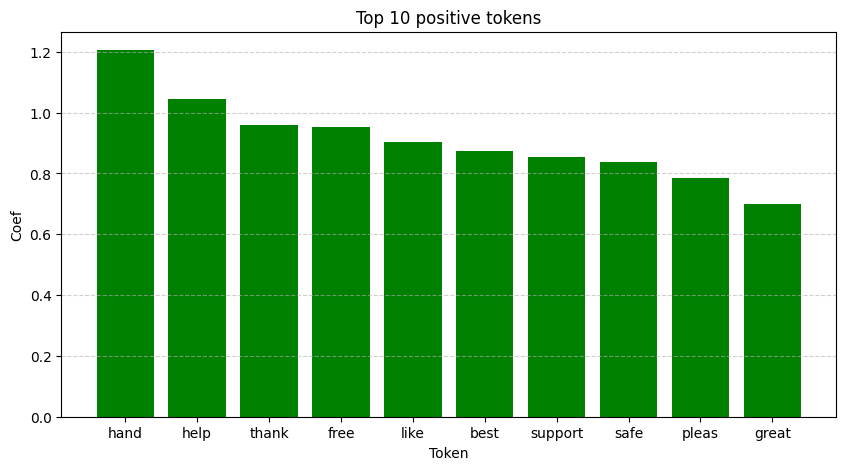

In [344]:
plt.figure(figsize=(10, 5))
plt.bar(df.nlargest(10, 'coef')['token'], df.nlargest(10, 'coef')['coef'], color='green')
plt.title('Top 10 positive tokens')
plt.xlabel('Token')
plt.ylabel('Coef')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

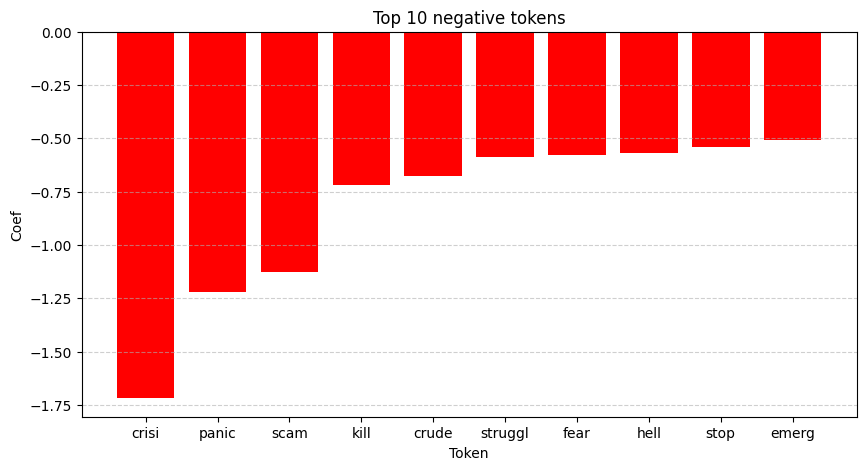

In [345]:
plt.figure(figsize=(10, 5))
plt.bar(df.nsmallest(10, 'coef')['token'], df.nsmallest(10, 'coef')['coef'], color='red')
plt.title('Top 10 negative tokens')
plt.xlabel('Token')
plt.ylabel('Coef')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

**Ответ:** Позитивные токены - это благодарности, слова связанные с поддержкой, помощью. То есть твитты, где люди благодарят кого-то будут положительно окрашены. Наиболее большой вес имеет токен, связанный с `hand` (скорее всего, твитты, где люди рекомендуют мыть руки, имеют положительный окрас), `free` - люди любят всё бесплатное, `help` - твитты с сообщением о помощи. И все эти токены имеют вес 0.8, что говорит о довольне хорошем вкладе в классификацию.

Негативные токены - это кризис, паника, страх, убиства, больной, то есть как раз-таки все слова с негативной окраской. Главные из них - `crisi`, `panic`, `scam` имеют наибольший коэффициент, больше $1$ по модулю. Остальные из топа имеют вес около $-0.5$.

При этом у негавтивных токенов есть три слова, которые явно выделяются, тогда как у положительных все имеют более плавную разницу коэффициентов.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [346]:
train['UserName'].values

array([28197, 38537, 23512, ..., 23451, 30284, 24178], shape=(23410,))

In [347]:
train['ScreenName'].values

array([73149, 83489, 68464, ..., 68403, 75236, 69130], shape=(23410,))

**Ответ:** Признаки `UserName` и `ScreenName` просто набор чисел, которые не несут никакой информации, кроме номера пользователя. Они практически не будут влиять на окрас твитта в данной задаче, поэтому они бессмысленны, их можно отбросить.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [348]:
train['TweetAt'].values

array(['26-03-2020', '08-04-2020', '24-03-2020', ..., '24-03-2020',
       '02-04-2020', '25-03-2020'], shape=(23410,), dtype=object)

In [349]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format='%d-%m-%Y')
train['TweetAt'].head(5)

20012   2020-03-26
28328   2020-04-08
16192   2020-03-24
31977   2020-04-12
11431   2020-03-21
Name: TweetAt, dtype: datetime64[ns]

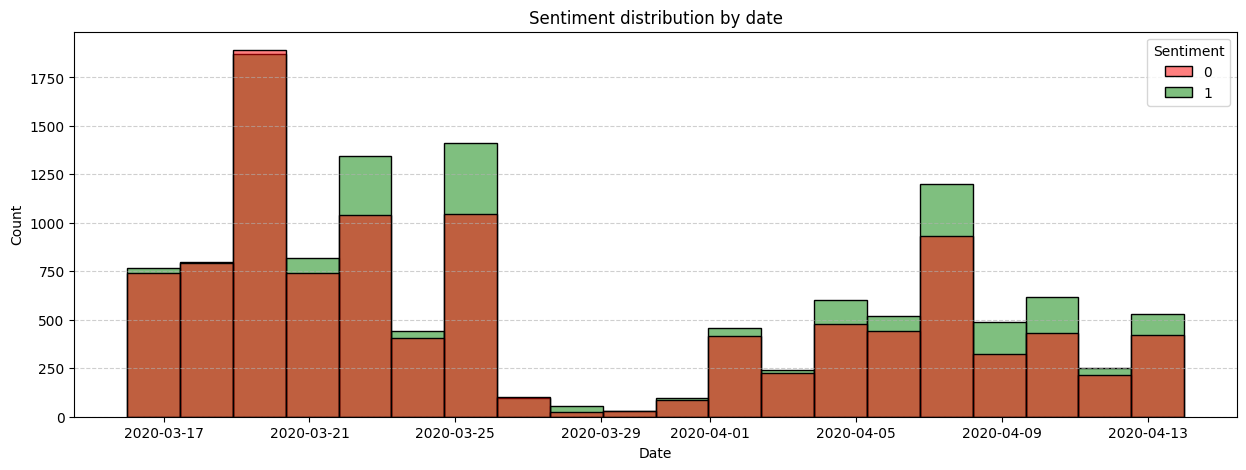

In [350]:
plt.figure(figsize=(15, 5))
sns.histplot(
    data=train, 
    x='TweetAt', 
    hue='Sentiment',
    palette=['red', 'green'],
    bins=20
)
plt.title('Sentiment distribution by date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

**Ответ:** В каждую дату количество положительных и негативных примерно одинаково, поэтому огромного смысла учитывать этот признак нет.

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [351]:
len(train['Location'].unique())

7887

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

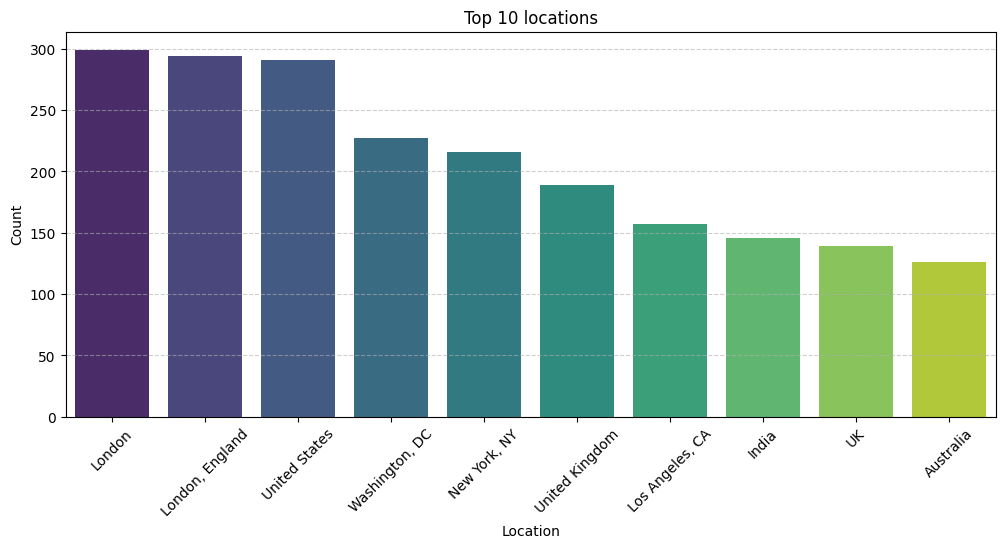

In [352]:
plt.figure(figsize=(12, 5))

location_counts = train['Location'].value_counts()
location_counts = location_counts.drop('Unknown')
top_locations = location_counts.head(10)
sns.barplot(
    hue=top_locations.index, 
    x=top_locations.index,
    y=top_locations.values, 
    palette='viridis',
    legend=False,
)

plt.title('Top 10 locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [353]:
train['WiderLocation'] = train['Location'].apply(lambda x: x.split(',')[-1])
test['WiderLocation'] = test['Location'].apply(lambda x: x.split(',')[-1])
len(train['WiderLocation'].unique())

5137

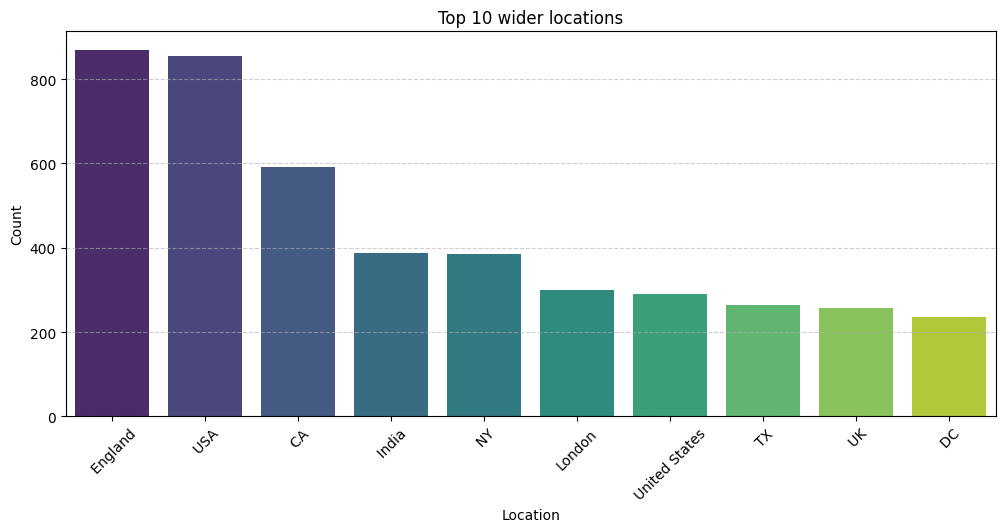

In [354]:
plt.figure(figsize=(12, 5))

wider_location_counts = train['WiderLocation'].value_counts()
wider_location_counts = wider_location_counts.drop('Unknown')
top_wider_locations = wider_location_counts.head(10)
sns.barplot(
    hue=top_wider_locations.index, 
    x=top_wider_locations.index,
    y=top_wider_locations.values, 
    palette='viridis',
    legend=False,
)

plt.title('Top 10 wider locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [355]:
valid_wider_lovations = wider_location_counts[wider_location_counts > 1].index.tolist()
len(valid_wider_lovations)

1151

In [356]:
from sklearn.preprocessing import OneHotEncoder

train_filtered = train[train['WiderLocation'].isin(valid_wider_lovations)].copy()

ohe = OneHotEncoder(handle_unknown='ignore', categories='auto')
ohe.fit(train_filtered[['WiderLocation']])

ohe_feature_names = ohe.get_feature_names_out(['WiderLocation'])

X_train_ohe = pd.DataFrame(
    ohe.transform(train_filtered[['WiderLocation']]).toarray(),
    columns=ohe_feature_names,
    index=train_filtered.index
)
X_test_ohe = pd.DataFrame(
    ohe.transform(test[['WiderLocation']]).toarray(),
    columns=ohe_feature_names,
    index=X_test.index
)

len(ohe.categories_[0])

1151

In [357]:
X_train_ohe.head(5)

,WiderLocation_,WiderLocation_,WiderLocation_ MN,WiderLocation_ 15401,WiderLocation_ 53719,WiderLocation_ ?,WiderLocation_ ??,WiderLocation_ ????,WiderLocation_ ????? ????,WiderLocation_ ??????,...,WiderLocation_she/her,WiderLocation_space,WiderLocation_texas,WiderLocation_toronto,WiderLocation_uk,WiderLocation_united states,WiderLocation_usa,WiderLocation_wales,WiderLocation_worldwide,WiderLocation_yo mama
28328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?

*Подсказка:* используйте параметр `categories` в энкодере.

In [358]:
X_train_cv_df_scaled = pd.DataFrame(X_train_cv_df_scaled, index=X_train.index)
selected_train_rows = X_train_cv_df_scaled.loc[X_train_ohe.index]
X_train_combined = pd.concat([selected_train_rows, X_train_ohe], axis=1)
y_train_filtered = y_train.loc[X_train_combined.index]

X_train_combined.columns = X_train_combined.columns.map(str)

X_test_cv_df_scaled = pd.DataFrame(X_test_cv_df_scaled, index=X_test.index)
selected_test_rows = X_test_cv_df_scaled.loc[X_test_ohe.index]
X_test_combined = pd.concat([selected_test_rows, X_test_ohe], axis=1)
y_test_filtered = y_test.loc[X_test_combined.index]

X_test_combined.columns = X_test_combined.columns.map(str)

In [359]:
assert list(X_train_combined.columns) == list(X_test_combined.columns)

In [360]:
log_reg = LogisticRegression(max_iter=300)
log_reg.fit(X_train_combined, y_train_filtered)

y_train_pred = log_reg.predict(X_train_combined)
y_test_pred = log_reg.predict(X_test_combined)
print(f'Accuracy Train: {accuracy_score(y_train_filtered, y_train_pred):.4f}')
print(f'Accuracy Test: {accuracy_score(y_test_filtered, y_test_pred):.4f}')

Accuracy Train: 0.9930
Accuracy Test: 0.7914


**Ответ:** Добавление признака местоположения не привело к улучшению точности модели по сравнению с теми, где использовали только текстовые признаки. Хоть на тренировочной выборке данные и улучшились почти до 100%, но на тестовой значения оказались на 5% меньше.

Это можно объяснить несколькими причинами:
1. Эмоциональная окраска твитта в основном определяется его текстовым содержанием, а не местоположением.
2. Из-за фильтрации по местоположениям, которые встречаются более 1 раза, были отсеяны твитты, которые помогали определять важные токены, то есть здесь мы не учитывали те твитты, у которых не определена страна.
3. Разные страны хоть и по-разному относились к пандемии, но этот факт не сильно влияет на модель. Возможно, было бы лучше работать с местополжением, потому что многие люди с одной страны по-разному относились к коронавирусу.
4. Пропуски в данных о местоположении ("Unknown") также снижают полезность признака местоположения.

В целом, для данной задачи классификации эмоциональной окраски твиттов признак местоположения оказался бесполезным, и достаточно использовать только текстовые признаки для достижения хорошей точности.

В этот раз без мема, но с фото Парижа! 🇫🇷🗼

![paris](https://raw.githubusercontent.com/vasyukov1/HSE-FCS-SE-2-year/refs/heads/main/IAD/homeworks/hw06-texts/paris.jpg)